In [1]:
'''Imports'''
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from prettytable import PrettyTable

'''Import Utils'''


'''Import Data'''
from sklearn.datasets import load_digits, fetch_california_housing

'''Import Data Processing Utilities'''
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, f1_score
from sklearn.decomposition import PCA

'''Import Predictors'''
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from skopt import BayesSearchCV

'''Import Tuning Utilities'''
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_objective, plot_histogram, plot_convergence, plot_gaussian_process
from sklearn.model_selection import GridSearchCV


In [2]:
'''Scoring Criteria Space'''
scoringCriteria = [
    'positive_likelihood_ratio', 'f1_micro', 'v_measure_score', 'roc_auc_ovr_weighted',
    'adjusted_rand_score', 'neg_mean_squared_log_error', 'r2', 'precision_macro',
    'roc_auc_ovo_weighted', 'neg_median_absolute_error', 'matthews_corrcoef', 'precision_samples',
    'jaccard_micro', 'balanced_accuracy', 'precision_micro', 'recall_micro', 'f1_samples',
    'recall', 'jaccard', 'neg_mean_poisson_deviance', 'rand_score', 'jaccard_weighted',
    'neg_mean_absolute_percentage_error', 'precision_weighted', 'average_precision',
    'neg_log_loss', 'recall_samples', 'recall_weighted', 'accuracy', 'homogeneity_score',
    'neg_mean_absolute_error', 'adjusted_mutual_info_score', 'roc_auc', 'completeness_score',
    'f1_macro', 'roc_auc_ovo', 'recall_macro', 'top_k_accuracy', 'f1', 'roc_auc_ovr',
    'normalized_mutual_info_score', 'fowlkes_mallows_score', 'mutual_info_score', 'explained_variance',
    'max_error', 'neg_negative_likelihood_ratio', 'neg_brier_score', 'neg_mean_squared_error',
    'f1_weighted', 'neg_root_mean_squared_error', 'jaccard_samples', 'neg_mean_gamma_deviance',
    'jaccard_macro', 'precision'
    ]

In [3]:
'''Fetch Regressor Data'''
cal_housing = fetch_california_housing(as_frame=True)
# print(cal_housing.data)
# print(cal_housing.target)

In [4]:
'''Regressor data EDA: Outliers'''

outlierTable = PrettyTable(['Feature', 'Outlier Count'])

for column in cal_housing.data.columns:
    Q1 = cal_housing.data[column].quantile(0.25)
    Q3 = cal_housing.data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outlierCount = np.array(cal_housing.data[column] >= upper).sum() + np.array(cal_housing.data[column] <= lower).sum()
    outlierTable.add_row([column, outlierCount])
    # print(f"{column}: {outlierCount}")

print(outlierTable)


+------------+---------------+
|  Feature   | Outlier Count |
+------------+---------------+
|   MedInc   |      681      |
|  HouseAge  |       0       |
|  AveRooms  |      511      |
| AveBedrms  |      1424     |
| Population |      1198     |
|  AveOccup  |      711      |
|  Latitude  |       0       |
| Longitude  |       0       |
+------------+---------------+


In [5]:
'''Data Cleaning and Pre-Processing: Outlier Removal'''
cleanData = cal_housing.data
cleanData['y'] = cal_housing.target

# cleanData = cleanData.drop(columns=['Longitude', 'Latitude'])
for feature in ['AveBedrms', 'AveRooms', 'AveOccup', 'Population']:
    cleanData = cleanData[(np.abs(stats.zscore(cleanData[feature])) < 2.5)]

# DATA CLEANING TODOs
# TODO: Bin Lat/Long groupings into city/town clusters. look for available geo-fencing data for cluster labeling - can we do a graph of centroids on top of map?
# TODO: Fix Skew for Population, MedIncome, AvgOccup, AvgBedroom, Target
# TODO: Feature Engineering / Reduction

cleanTarget = cleanData['y'].to_list()
cleanData.drop(columns=['y'], inplace=True)

In [26]:
modelData = cleanData.copy()



paramSpace = {
            'regress__criterion': ['squared_error','poisson'],
            'regress__max_depth': Integer(500,1000),
            'regress__min_samples_split': Real(0.1, 0.3),
            'regress__min_samples_leaf': Real(0.1, 0.4),
            'regress__max_features': Real(0.4, 0.9)
        }

X_train, X_test, y_train, y_test = train_test_split(modelData, cleanTarget, test_size=0.3, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('regress',DecisionTreeRegressor())])
opt = BayesSearchCV(
    pipe,
    paramSpace,
    n_iter=30,
    cv=10,
    )
opt.fit(X_train, y_train)
predicted = opt.best_estimator_.predict(X_test)
print('Evaluation Metric:', opt.get_params()['scoring'])
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

Evaluation Metric: None
val. score: 0.5036390146975445
test score: 0.47690323395707435


In [7]:
print(opt.optimizer_results_[0].models)


[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=536237991), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=536237991), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=536237991), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
           

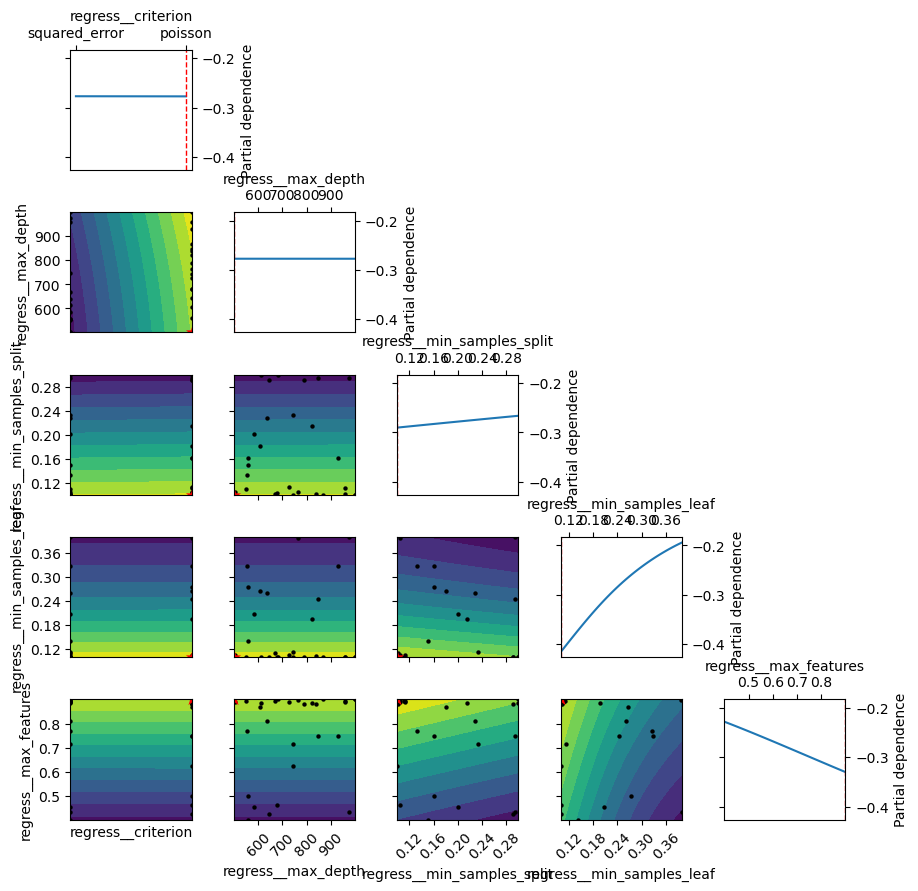

In [27]:
ax = plot_objective(result=opt.optimizer_results_[0],
                plot_dims=list(paramSpace.keys()),
                n_minimum_search=int(1e8))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()
